In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import matplotlib.image as pltimg
import graphviz 

############################
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor,VotingClassifier,RandomForestClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, KFold, train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
from sklearn.tree._export import plot_tree

In [12]:
df_Nacional = pd.read_csv('C:\Users\aleon\Documents\TCC\DICIONÁRIO', sep = ';', encoding='ISO 8859-1')
df_Nacional = df_Nacional.loc[:, ~df_Nacional.columns.str.contains('^Unnamed')]
df_Alagoas = pd.read_csv('../microdadosEnemAlagoas.csv', sep = ';', encoding='ISO 8859-1')
df_Alagoas = df_Alagoas.loc[:, ~df_Alagoas.columns.str.contains('^Unnamed')]

In [5]:
df_dicionario = pd.read_csv('../dicionário reduzido.csv', sep = ',')
df_dicionario

,DICIONÁRIO DE VARIÁVEIS - ENEM 2018 - (Modificado),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,NOME DA VARIÁVEL,Descrição,Variáveis Categóricas,NaN,Tipo
2,NaN,NaN,Categoria,Descrição,NaN
3,DADOS DO PARTICIPANTE,NaN,NaN,NaN,NaN
4,NU_INSCRICAO,Número de inscrição1,NaN,NaN,Numérica
...,...,...,...,...,...
204,7. A opção de certificação só é apresentada pa...,NaN,NaN,NaN,NaN
205,8. As 45 primeiras posições deste campo são re...,NaN,NaN,NaN,NaN
206,9. As 45 primeiras posições deste campo são re...,NaN,NaN,NaN,NaN
207,10. As 45 primeiras posições deste campo são r...,NaN,NaN,NaN,NaN


In [15]:
# feature-cols vai armazenar todas as colunas exceto a coluna que armazena as
# notas de matemática do participante de Alagoas
feature_cols = [x for x in df_Alagoas.columns if x != 'NU_NOTA_MT']
X = df_Alagoas[feature_cols]
Y = df_Alagoas['NU_NOTA_MT']
X2= df_Nacional[feature_cols]
Y2 = df_Nacional['NU_NOTA_MT']


In [16]:
# Leitura dos datasets de treino e teste e criação do df de resposta
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split( X2, Y2, test_size=0.3, random_state=0)
#test-size = 0.3 define que o tamanho da base de teste é de 30% da base principal, e a base de treino é 70%

#visualizando os tamanhos da bases, teino e teste
print(X.shape, Y.shape, X_train.shape, y_train.shape ,X_test.shape, y_test.shape)

(64605, 40) (64605,) (45223, 40) (45223,) (19382, 40) (19382,)


In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = ['NU_IDADE', 'TP_SEXO','TP_ESTADO_CIVIL', 'TP_COR_RACA','TP_ANO_CONCLUIU', 'TP_ESCOLA',
                    'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO',  'Q005']

numeric_transformer = Pipeline(   steps=[ ('scaler', StandardScaler())])

categorical_features = ['Q001', 'Q002', 'Q003', 'Q004','Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011','Q012', 'Q013', 'Q014',
                        'Q015','Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

X_train = X_train[numeric_features + categorical_features]
X_test = X_test[numeric_features + categorical_features]
X2_train = X2_train[numeric_features + categorical_features]
X2_test = X2_test[numeric_features + categorical_features]

preprocessing = ColumnTransformer(transformers=[
                                        ('num', numeric_transformer, numeric_features),                                       
                                        ('cat', categorical_transformer, categorical_features),  
])

In [18]:
feature_names= numeric_features + categorical_features
len(feature_names)
print(feature_names)

['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'Q005', 'Q001', 'Q002', 'Q003', 'Q004', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']


In [19]:
rf = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42 ))
])
rf.fit(X_train, y_train)
rf2 = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42 ))
])
rf2.fit(X2_train, y2_train)


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['NU_IDADE', 'TP_SEXO',
                                                   'TP_ESTADO_CIVIL',
                                               

In [ ]:
Q002_A
Q001_H
Q002_B
Q002_C
Q001_A
Q001_B
Q002_D
Q001_E
Q001_D
Q026_A
Q006_H

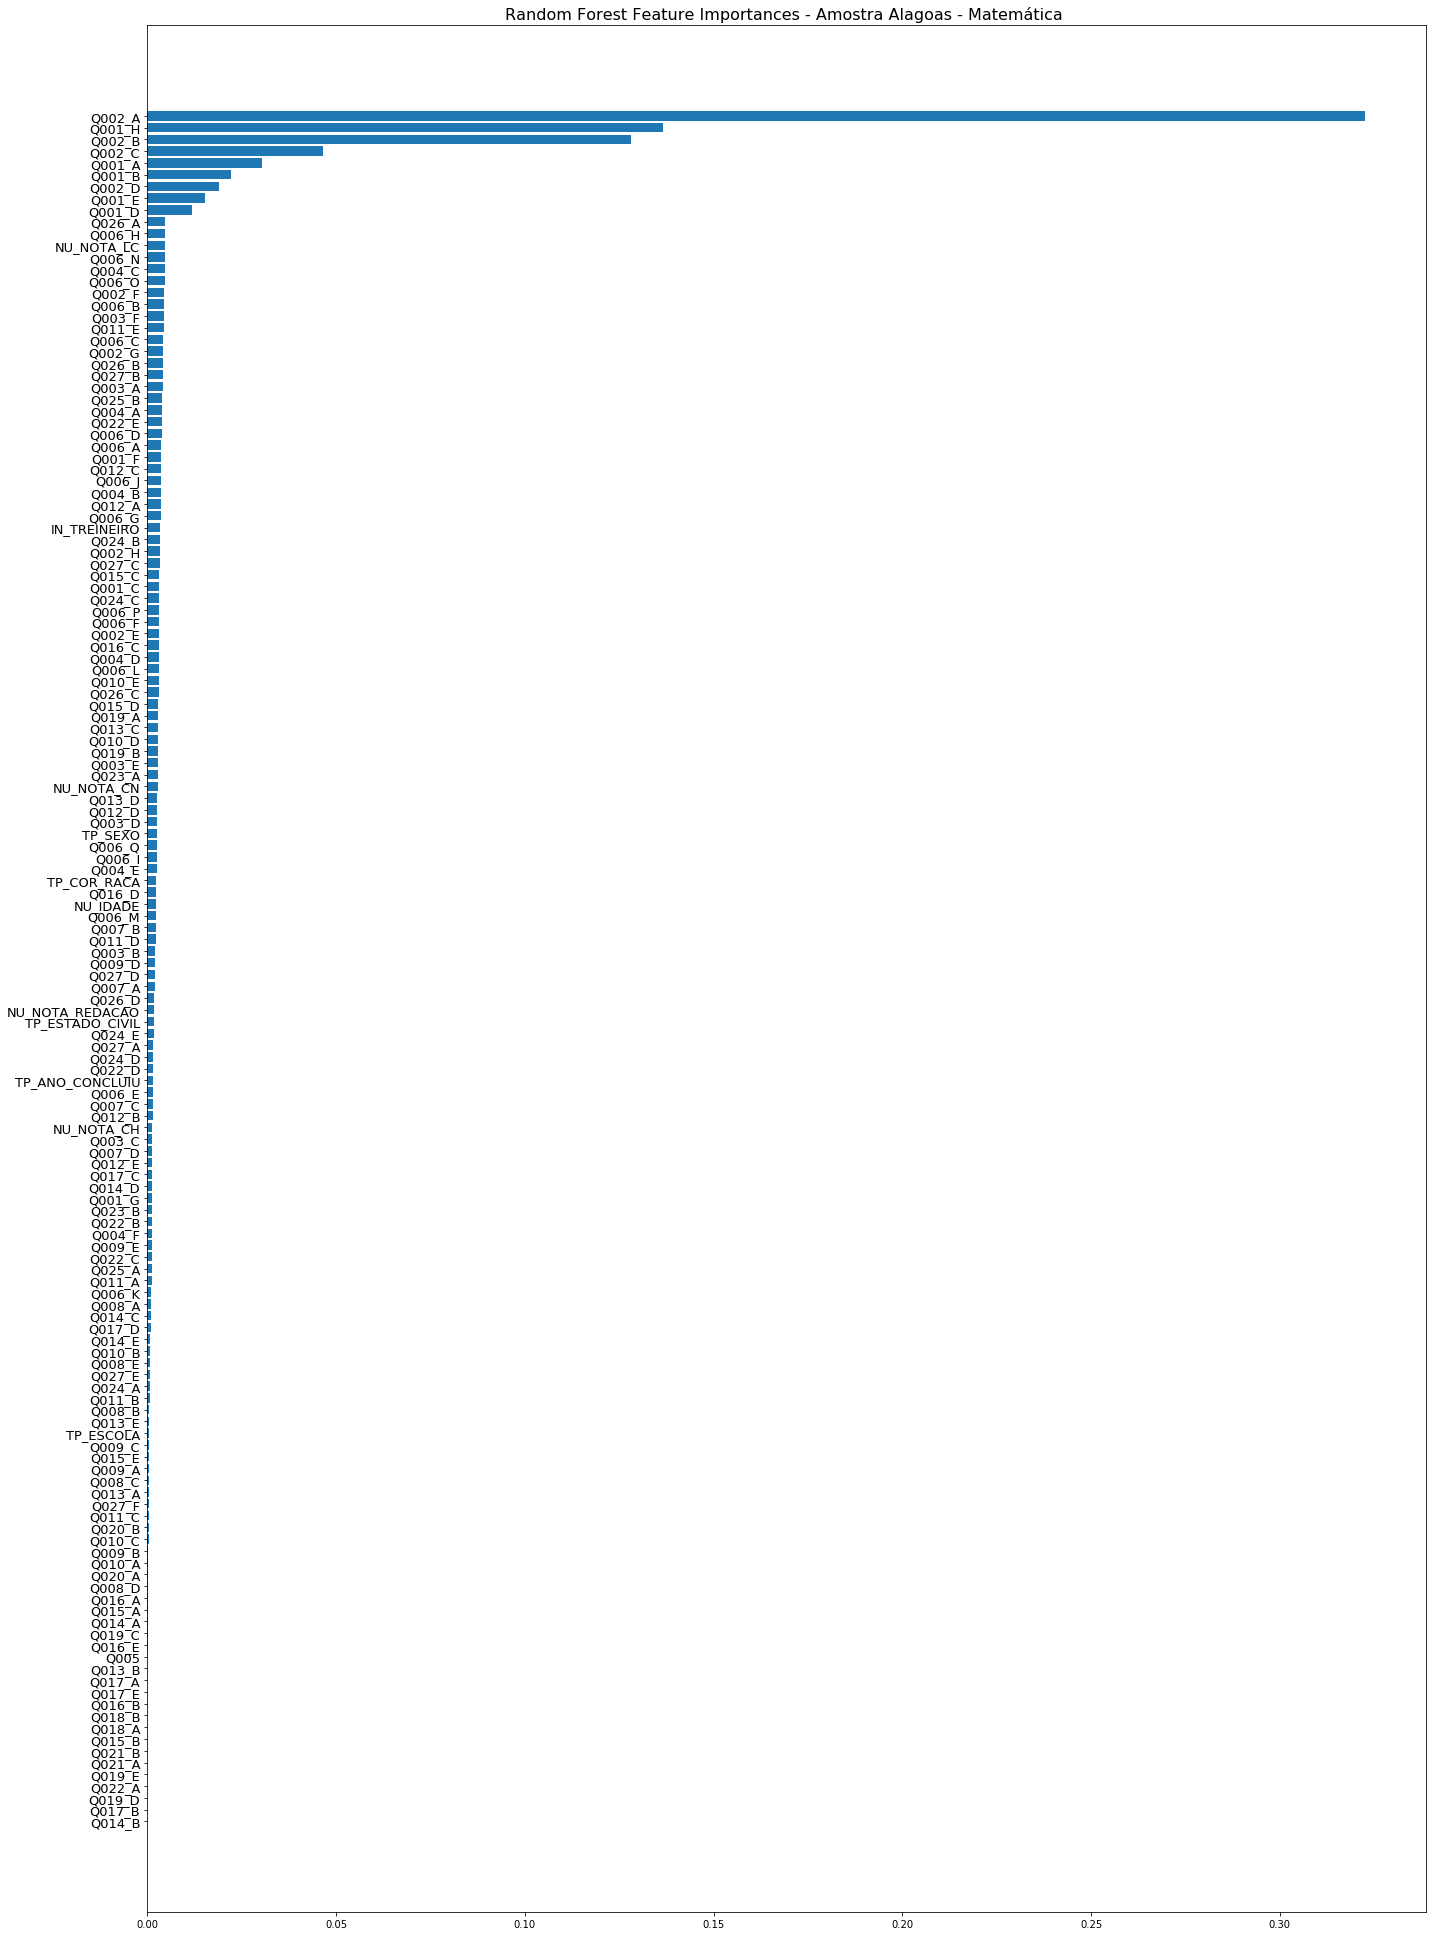

In [39]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 27))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances - Amostra Alagoas - Matemática ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesRF_AL_MT.png', format='png')
plt.show()

In [ ]:
Q002_A : 
Q001_H
Q002_B
Q002_C
Q001_A
Q001_B
Q002_D
Q001_E
Q001_D
Q026_A
Q006_H

Q002:
A
B
C
D

Q001
A
B
E
H

Q006:
N
H

Q003:
A

Q025:
B


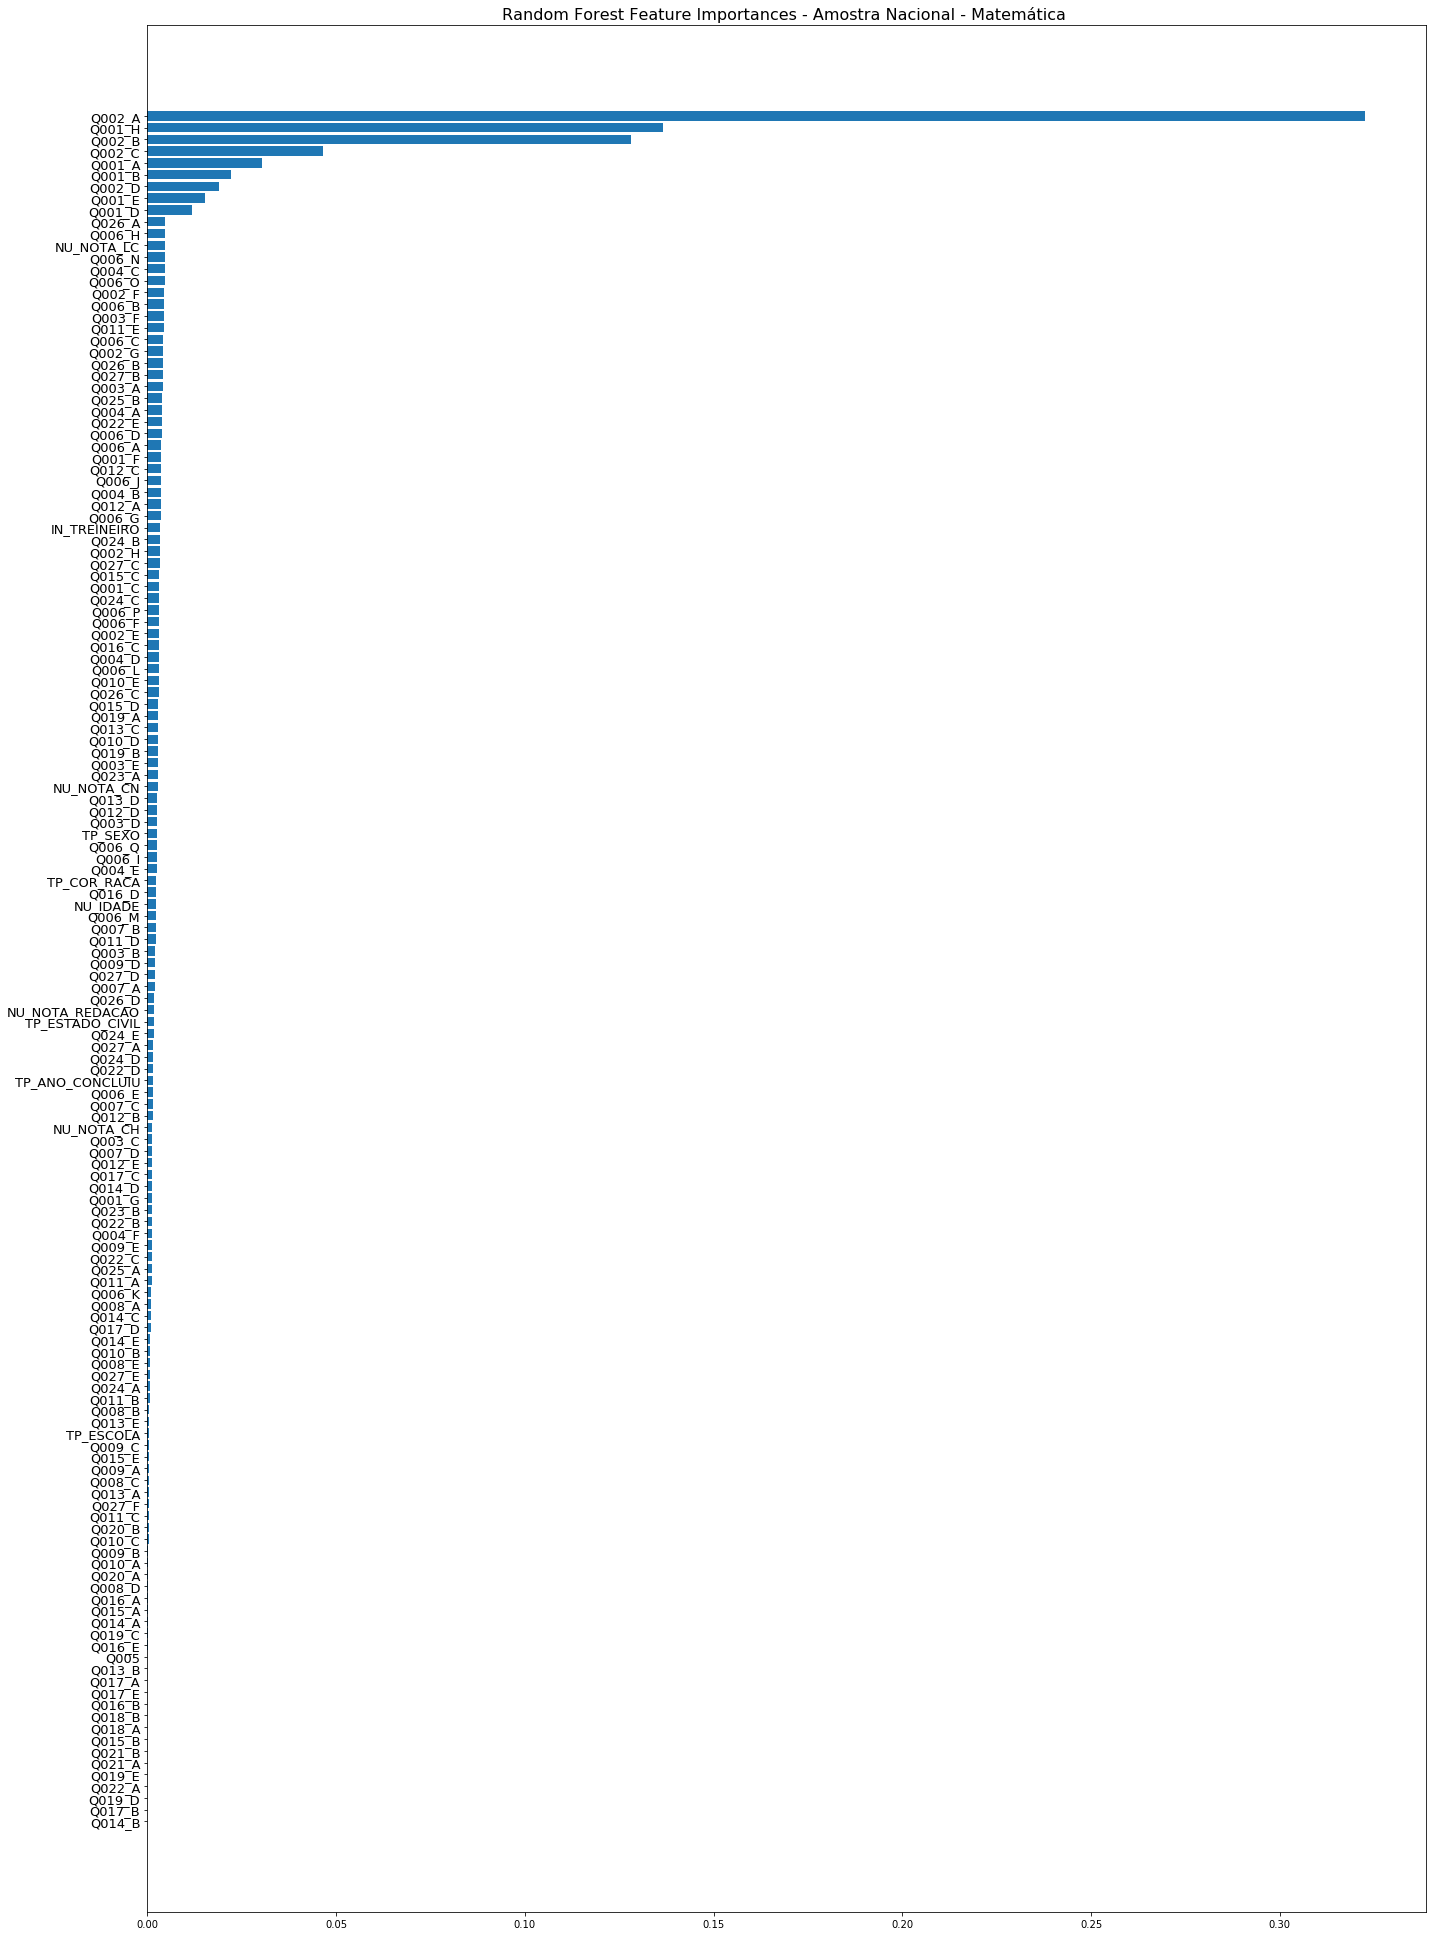

In [37]:
ohe = (rf2.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf2.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 27))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances - Amostra Nacional - Matemática ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesRF_BR_MT.png', format='png')
plt.show()

In [56]:
dtree = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', DecisionTreeRegressor(random_state=0))
])
dtree.fit(X_train, y_train)
dtree2 = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', DecisionTreeRegressor(random_state=0))
])
dtree2.fit(X2_train, y2_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['NU_IDADE', 'TP_SEXO',
                                                   'TP_ESTADO_CIVIL',
                                               

In [ ]:
Q002_A
Q001_H
Q002_B
Q002_C
Q001_A
Q001_B
Q002_D
Q001_E
Q006_N
Q003_A
Q025_B
Q006_H


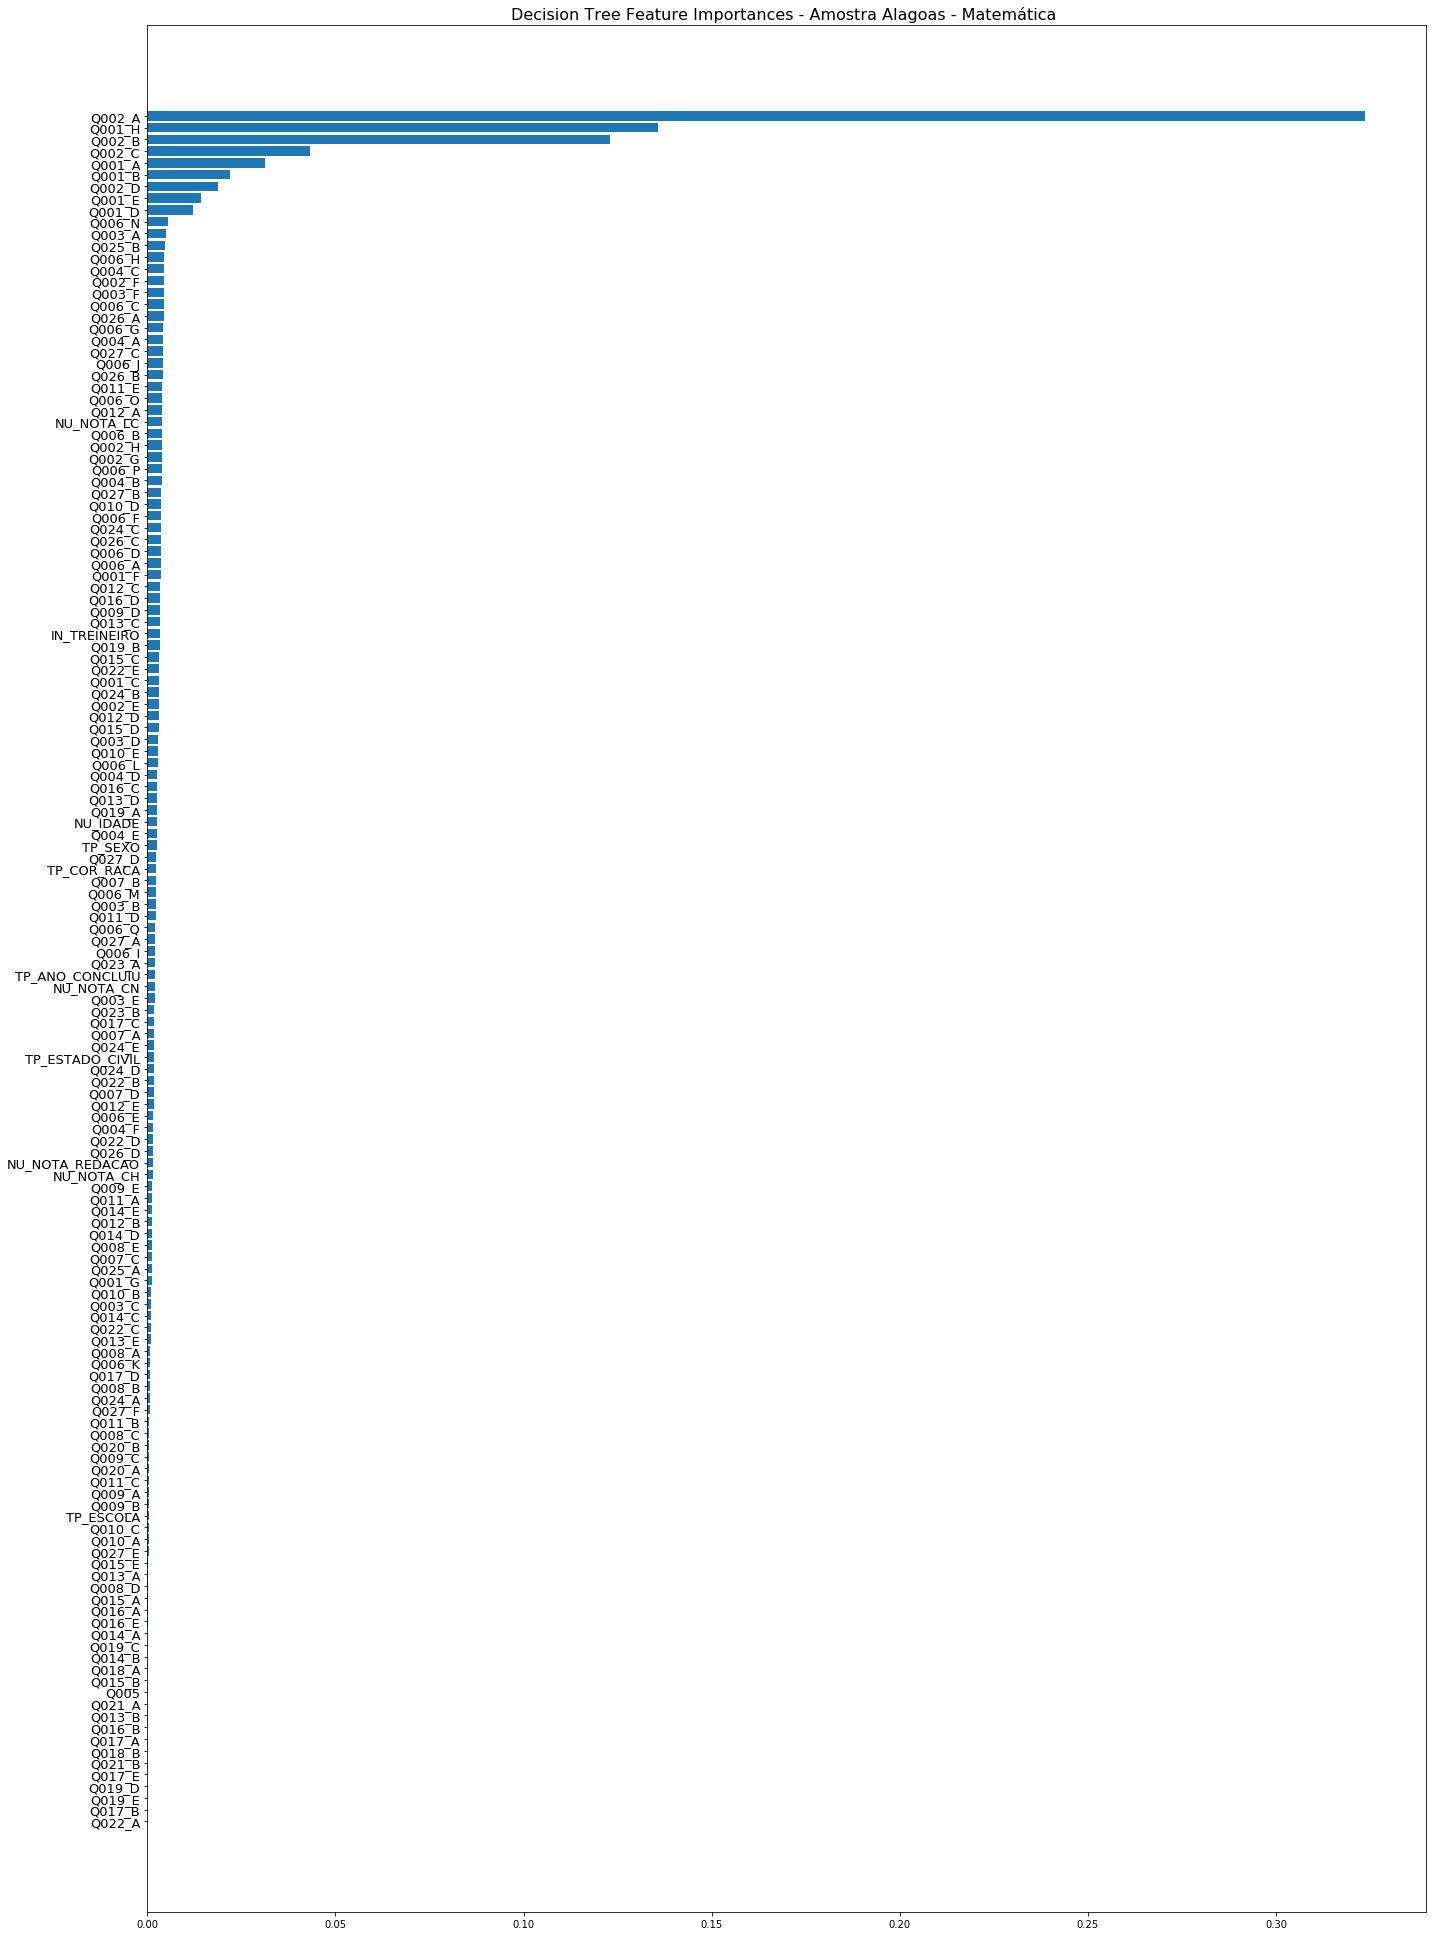

In [57]:
ohe = (dtree.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 27))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Decision Tree Feature Importances - Amostra Alagoas - Matemática ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesDT_AL_MT.png', format='png')
plt.show()

In [ ]:
Q002_A
Q001_H
Q002_B
Q002_C
Q001_A
Q001_B
Q002_D
Q001_E
Q006_N
Q003_A
Q025_B
Q006_H


Os resultados das importâncias das features para o modelo Árvore de decisão foram iguais, tanto para base nacional quanto para base de alagoas, as 10 features mais importantes foram classficadas nas mesmas posições e com as mesma porcetagens.
Para esse modelo as features que tiveram maior importância foram as que tratavam da seguinte pergunta:

Q001:
Alternativas:
A:
B:
C:
D:
E:

Q002:
A
B
C
D

Q006:
N:
H:

Q003:
A:

Q025:
B


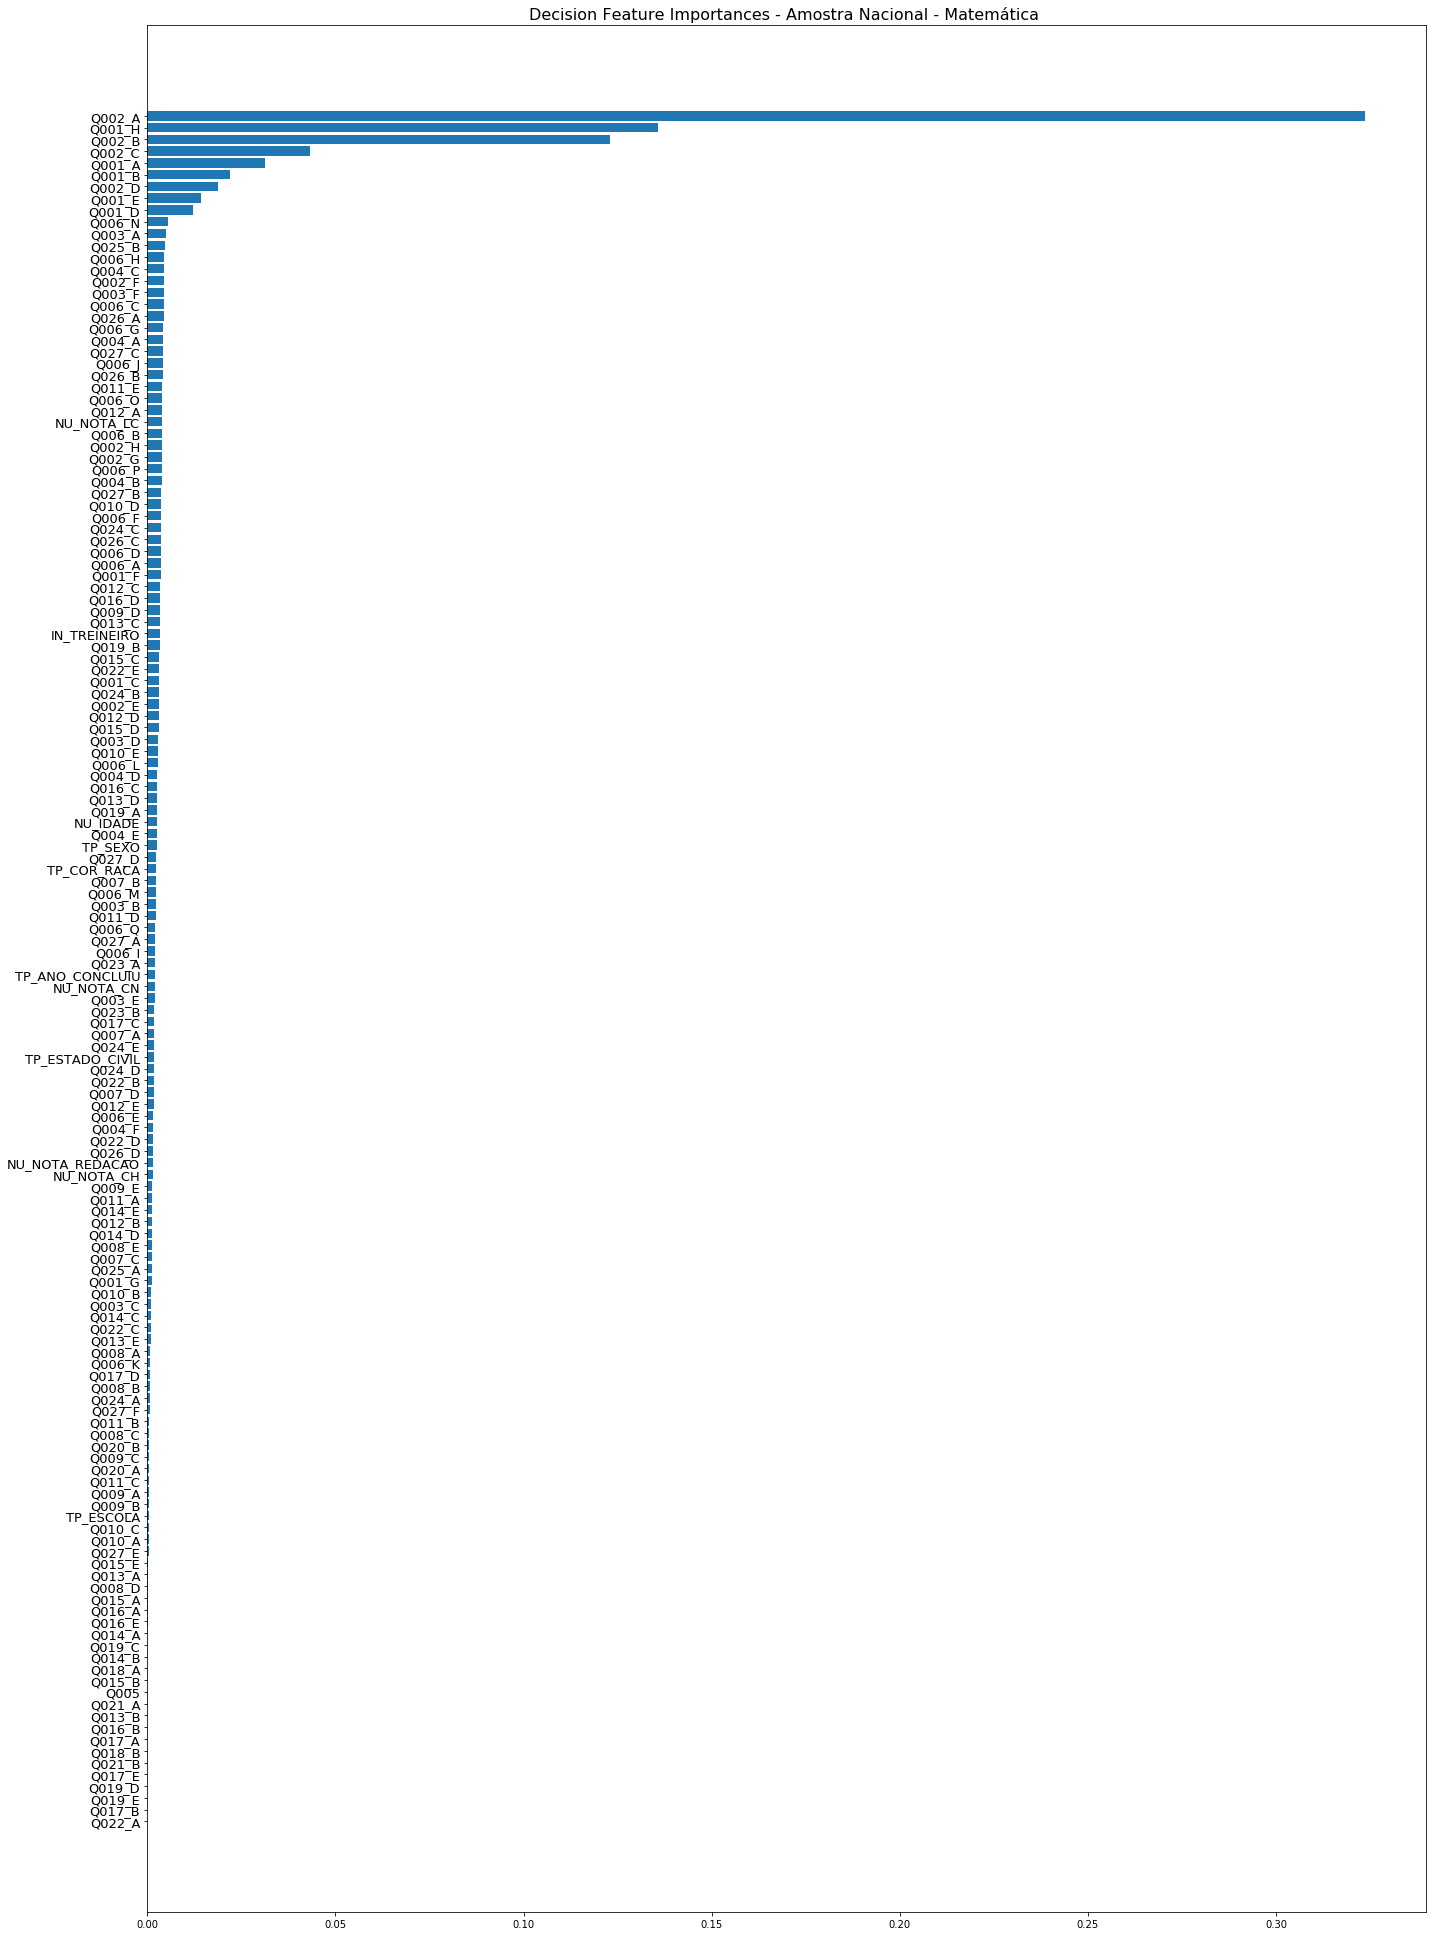

In [58]:
ohe = (dtree2.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree2.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 27))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Decision Feature Importances - Amostra Nacional - Matemática ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesDT_BR_MT.png', format='png')
plt.show()

In [31]:
df_RF = pd.DataFrame()
df_DT = pd.DataFrame()

In [60]:

ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf.named_steps['regressor'].feature_importances_)
tree_feature_importances2 = (rf2.named_steps['regressor'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()
sorted_idx2 = tree_feature_importances2.argsort()

features_importance = zip(tree_feature_importances, feature_names)
features_importance2 = zip(tree_feature_importances2, feature_names)


print()
labels = []
importances = []
l2 = []
i=[]
for importance, feature, in sorted(features_importance, reverse=True):
    
    x = round(importance*100, 2)
    labels.append(feature)
    importances.append(x)    
    print("%s: %f%%" % (feature, importance*100)) 
for importance, feature, in sorted(features_importance2, reverse=True):
    
    x = round(importance*100, 2)
    l2.append(feature)
    i.append(x)    
    print("%s: %f%%" % (feature, importance*100)) 
    

df_RF['importances RF AL'] = importances
df_RF['features'] = labels
df_RF['importances RF NA'] = i
df_RF['features'] = l2


print(importances)


Q002_A: 32.250137%
Q001_H: 13.654667%
Q002_B: 12.810070%
Q002_C: 4.650045%
Q001_A: 3.032966%
Q001_B: 2.226458%
Q002_D: 1.906226%
Q001_E: 1.515700%
Q001_D: 1.175537%
Q026_A: 0.479403%
Q006_H: 0.479238%
NU_NOTA_LC: 0.476733%
Q006_N: 0.473867%
Q004_C: 0.465314%
Q006_O: 0.464333%
Q002_F: 0.452279%
Q006_B: 0.449188%
Q003_F: 0.445014%
Q011_E: 0.428966%
Q006_C: 0.421206%
Q002_G: 0.419505%
Q026_B: 0.411525%
Q027_B: 0.404151%
Q003_A: 0.403330%
Q025_B: 0.388576%
Q004_A: 0.385214%
Q022_E: 0.380185%
Q006_D: 0.378373%
Q006_A: 0.372048%
Q001_F: 0.369369%
Q012_C: 0.364448%
Q006_J: 0.364350%
Q004_B: 0.358528%
Q012_A: 0.352243%
Q006_G: 0.350929%
IN_TREINEIRO: 0.343461%
Q024_B: 0.341261%
Q002_H: 0.333478%
Q027_C: 0.324181%
Q015_C: 0.322824%
Q001_C: 0.320990%
Q024_C: 0.320702%
Q006_P: 0.316099%
Q006_F: 0.315374%
Q002_E: 0.309685%
Q016_C: 0.303652%
Q004_D: 0.303635%
Q006_L: 0.302231%
Q010_E: 0.301891%
Q026_C: 0.298958%
Q015_D: 0.296403%
Q019_A: 0.293760%
Q013_C: 0.292363%
Q010_D: 0.284609%
Q019_B: 0.2793

In [61]:
df_RF

,importances RF,features,importances RF AL,importances RF NA
0,32.25,Q002_A,32.25,32.25
1,13.65,Q001_H,13.65,13.65
2,12.81,Q002_B,12.81,12.81
3,4.65,Q002_C,4.65,4.65
4,3.03,Q001_A,3.03,3.03
...,...,...,...,...
141,0.00,Q019_E,0.00,0.00
142,0.00,Q022_A,0.00,0.00
143,0.00,Q019_D,0.00,0.00
144,0.00,Q017_B,0.00,0.00


In [29]:

ohe = (dtree.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

features_importance = zip(tree_feature_importances, feature_names)

print()
labels = []
importances = []
for importance, feature, in sorted(features_importance, reverse=True):
    
    x = round(importance*100, 2)
    labels.append(feature)
    importances.append(x)    
    print("%s: %f%%" % (feature, importance*100))  

df_DT['importances DT'] = importances
df_DT['features'] = labels

print(importances, labels)

NameError: name 'dtree' is not defined

In [28]:
df.sample(100).plot.bar(stacked=True, figsize=(20,10));

NameError: name 'df' is not defined